# London Bike Sharing

In this notebook, we are going to visualize the London bike sharing data and try to predict it

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

/kaggle/input/london-bike-sharing-dataset/london_merged.csv


# 1.Data Preparation

In [2]:
df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
to_int = ['weather_code', 'season', 'is_holiday', 'is_weekend']
for col in to_int:
    df[col] = df[col].astype(int)

df['timestamp'] = pd.to_datetime(df['timestamp'])

#creating new columns fot the year, month, day, and day of the week
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['day_of_week'] += 1 #changing the index to map monday as 1 instead of 0
df['hour'] = df['timestamp'].dt.hour

In [4]:
ordered_cols =['year', 'month', 'season', 'day', 'day_of_week', 'is_weekend', 'is_holiday', 'hour', 'cnt', 't1', 't2', 'weather_code', 'hum', 'wind_speed']
df = df[ordered_cols]
df.head()

,year,month,season,day,day_of_week,is_weekend,is_holiday,hour,cnt,t1,t2,weather_code,hum,wind_speed
0,2015,1,3,4,7,1,0,0,182,3.0,2.0,3,93.0,6.0
1,2015,1,3,4,7,1,0,1,138,3.0,2.5,1,93.0,5.0
2,2015,1,3,4,7,1,0,2,134,2.5,2.5,1,96.5,0.0
3,2015,1,3,4,7,1,0,3,72,2.0,2.0,1,100.0,0.0
4,2015,1,3,4,7,1,0,4,47,2.0,0.0,1,93.0,6.5


# 2. Data Visualization

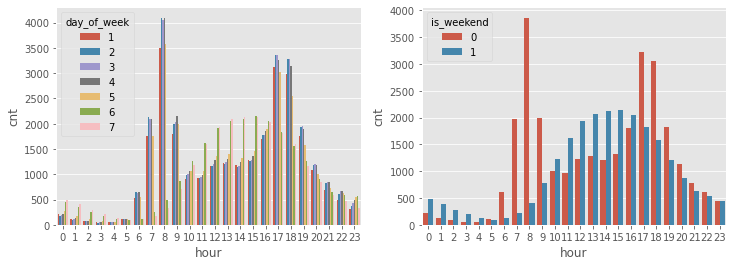

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

weekly = df.groupby(['hour', 'day_of_week'])['cnt'].mean().reset_index()
weekend = df.groupby(['hour', 'is_weekend'])['cnt'].mean().reset_index()

sns.barplot(ax=ax[0], data=weekly, x='hour', y='cnt', hue='day_of_week')
sns.barplot(ax=ax[1], data=weekend, x='hour', y='cnt', hue='is_weekend')

plt.show()

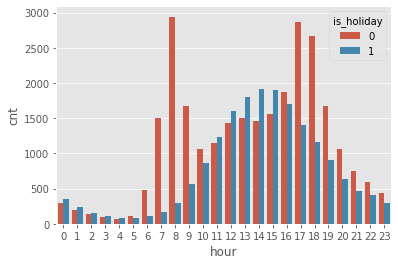

In [6]:
holidays = df.groupby(['hour', 'is_holiday'])['cnt'].mean().reset_index()
sns.barplot(data=holidays, x='hour', y='cnt', hue='is_holiday')
plt.show()

There is a clear difference between weekdays and weekend
* weekdays have two peak matching the commuting time
* during weekends and holidays, people mostly rent the bike in the afternoon

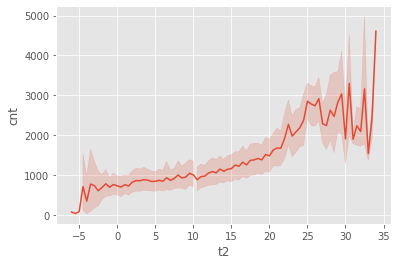

In [7]:
temp = df.groupby(['hour', 't2'])['cnt'].mean().reset_index()
sns.lineplot(data=temp, x='t2', y='cnt')
plt.show()

* bike rentals rise progressivily until 25 degrees
* bike rentals seem to plateau above 25 degrees

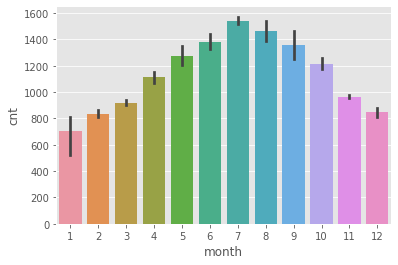

In [8]:
monthly = df.groupby(['year', 'month'])['cnt'].mean().reset_index()
sns.barplot(data=monthly, x='month', y='cnt')
plt.show()

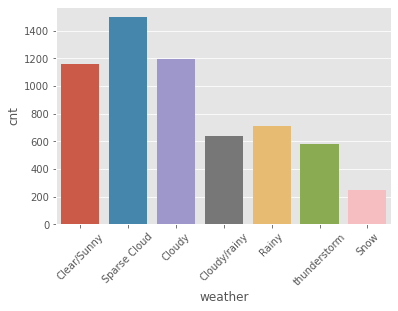

In [9]:
rainy = df.groupby(['weather_code'])['cnt'].mean().reset_index()
weather_map = {1.0: 'Clear/Sunny', 2.0:'Sparse Cloud', 3.0:'Cloudy', 4.0:'Cloudy/rainy', 7.0:'Rainy', 10.0:'thunderstorm', 26.0:"Snow"}
rainy['weather'] = rainy['weather_code'].map(weather_map)
sns.barplot(data=rainy, x='weather', y='cnt')
plt.xticks(rotation=45)
plt.show()

* we can see that there are more rentals during the summer
* there's also more rental when the weather is good, but not too sunny

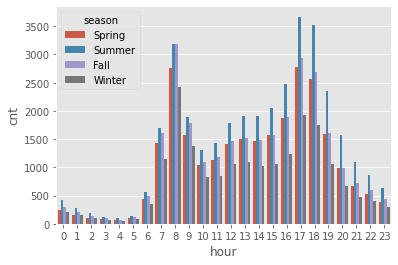

In [10]:
season = df.groupby(['hour', 'season'])['cnt'].mean().reset_index()
seasons = {0: "Spring", 1:"Summer", 2:"Fall", 3:"Winter"}
season['season'] = season['season'].map(seasons)
sns.barplot(data=season, x='hour', y='cnt', hue='season')
plt.show()

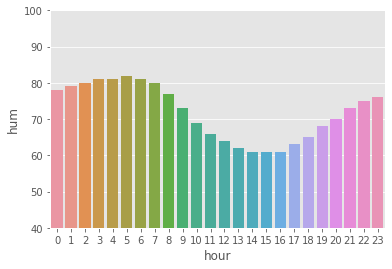

In [11]:
hum_per_hour = df.groupby('hour')['hum'].mean().reset_index()
hum_per_hour['hum'] = hum_per_hour['hum'].astype('int')
sns.barplot(data=hum_per_hour, x='hour', y='hum')
plt.ylim([40, 100])
plt.show()

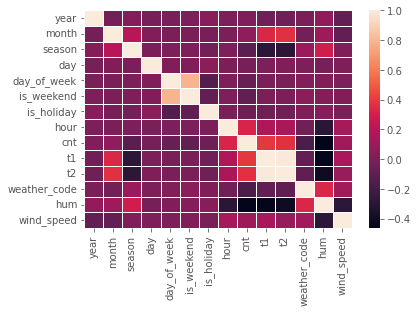

In [12]:
corr = df.corr()
sns.heatmap(corr, linewidths=0.5)
plt.show()

In [13]:
corr['cnt']

year            0.010046
month           0.063757
season         -0.116180
day            -0.017887
day_of_week    -0.068688
is_weekend     -0.096499
is_holiday     -0.051698
hour            0.324423
cnt             1.000000
t1              0.388798
t2              0.369035
weather_code   -0.166633
hum            -0.462901
wind_speed      0.116295
Name: cnt, dtype: float64

# 3. Machine Learning Model

After testing different models, it seems the decision tree gives the best prediction

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae

In [15]:
weather_map = {1:'good', 2:'great', 3:'good', 4:'rainy', 7:'rainy', 10:'rainy', 26:'snowy'}
weather_map2 = {'great': 2, 'good': 1, 'rainy': -1, 'snowy': -2}
df['weather'] = df['weather_code'].map(weather_map)
df['weather'] = df['weather'].map(weather_map2)

to_drop = ['t2', 'year', 'month', 'day', 'weather_code']
df.drop(to_drop, axis=1, inplace=True)
df.head()

,season,day_of_week,is_weekend,is_holiday,hour,cnt,t1,hum,wind_speed,weather
0,3,7,1,0,0,182,3.0,93.0,6.0,1
1,3,7,1,0,1,138,3.0,93.0,5.0,1
2,3,7,1,0,2,134,2.5,96.5,0.0,1
3,3,7,1,0,3,72,2.0,100.0,0.0,1
4,3,7,1,0,4,47,2.0,93.0,6.5,1


In [16]:
y = df['cnt']
X = df.drop('cnt', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae_score = mae(y_test, y_pred)

print(f'the mean absolute error for the decision tree is {round(mae_score, 2)}')
print(f'while the mean rentals number is: {round(y_test.mean(), 2)}')

the mean absolute error for the decision tree is 179.34
while the mean rentals number is: 1145.96


In [18]:
graph = X_test.copy()
graph['truth'] = y_test.iloc[:]
graph['pred'] = y_pred
graph['perc_err'] = np.abs((graph['truth'] - graph['pred']) / graph['truth'])

number of predictions with an error under 25.0%: 2484
number of predictions with a larger error: 999


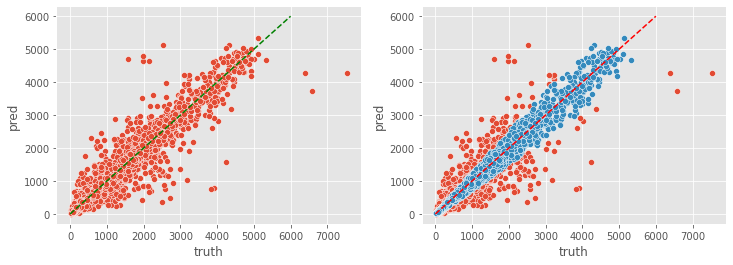

In [19]:
line=[0,6000]
threshold = 0.25
outliers = graph[graph['perc_err'] >= threshold]
inliers = graph[graph['perc_err'] < threshold]
print(f'number of predictions with an error under {threshold * 100}%: {inliers.shape[0]}')
print(f'number of predictions with a larger error: {outliers.shape[0]}')

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.scatterplot(ax=ax[0], data=graph, x='truth', y='pred')
sns.lineplot(ax=ax[0], x=line, y=line, color='green', linestyle='--')

sns.scatterplot(ax=ax[1], data=outliers, x='truth', y='pred')
sns.scatterplot(ax=ax[1], data=inliers, x='truth', y='pred')
sns.lineplot(ax=ax[1], x=line, y=line, color='red', linestyle='--')

plt.show()

it is a bit difficult to see the distribtion on the graph because , let's take a sample of the dataframes to have a more readable scatterplot

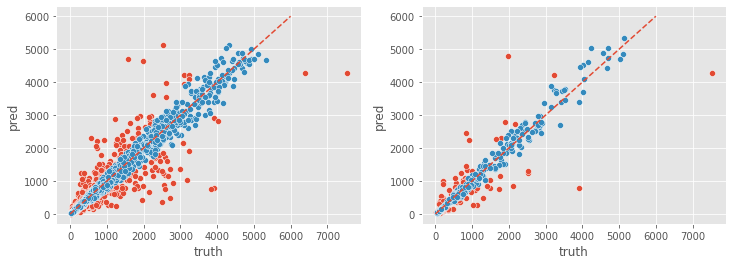

In [20]:
outliers_50 =  outliers.sample(frac=0.5)
inliers_50 = inliers.sample(frac=0.5)

outliers_10 = outliers.sample(frac=0.1)
inliers_10 = inliers.sample(frac=0.1)

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.scatterplot(ax=ax[0], data=outliers_50, x='truth', y='pred')
sns.scatterplot(ax=ax[0], data=inliers_50, x='truth', y='pred')
sns.lineplot(ax=ax[0], x=line, y=line, linestyle='--')

sns.scatterplot(ax=ax[1], data=outliers_10, x='truth', y='pred')
sns.scatterplot(ax=ax[1], data=inliers_10, x='truth', y='pred')
sns.lineplot(ax=ax[1], x=line, y=line, linestyle='--')

plt.show()

Here, we have taken 50% and 10% of the test dataframe to have a better look at the prediction.

We can see that most of the prediction are close to the regression line

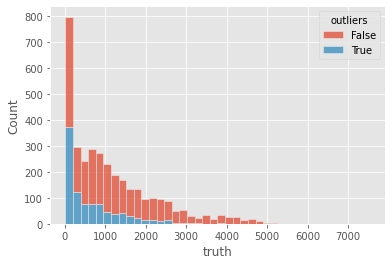

In [21]:
graph['outliers'] = graph['perc_err'] > threshold
sns.histplot(data=graph, x='truth', hue='outliers', multiple='stack')
plt.show()

In this last plot, we can see that most of the prediction with an error above 25% occurs for low count rental

# Summary

In this notebook we have visualized the london bike rentals data, and looked at the pattern influencing the rentals.
70% of predictions made by the decision tree were having an error under 25%
